<a href="https://colab.research.google.com/github/HodaMemar/A3/blob/main/Multi_label_Jovian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://jovian.ai/kyawkhaung/1-titles-only-for-medium/v/1&cellId=10

In [1]:
!pip install transformers
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import pickle
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, AdamW
from tqdm import tqdm, trange
from ast import literal_eval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 101 kB 12.8 MB/s 
     |████████████████████████████████| 6.6 MB 48.1 MB/s 
     |████████████████████████████████| 596 kB 72.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


https://cloud.tencent.com/developer/article/1814597

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [4]:
!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr
To: /content/toxic_comments.csv
100% 68.8M/68.8M [00:00<00:00, 143MB/s]


In [5]:
! ls

sample_data  toxic_comments.csv


In [6]:
df = pd.read_csv('toxic_comments.csv')
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [7]:
df['offensive']=np.zeros(24783)
df['k']=np.zeros(24783)
df['j']=np.zeros(24783)
for i in range(0,24783):
  if str(df['label'][i])== '2':
       df['offensive'][i]=1
      #df['j'][i]=0
      
  elif str(df['label'][i])=='0':
      #df['offensive'][i]=0
      df['k'][i]=1
      #df['j'][i]=0
  
  elif str(df['label'][i])=='1':
      #df['offensive'][i]=0
      #df['k'][i]=0
      df['j'][i]=1

df

ValueError: ignored

In [8]:
cols = df.columns
label_cols = list(cols)
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [9]:
num_labels

8

In [ ]:
#print('Count of 1 per label: \n', df[label_cols].sum(), '\n') # Label counts, may need to downsample or upsample
#print('Count of 0 per label: \n', df[label_cols].eq(0).sum())

In [10]:
df = df.sample(frac=1).reset_index(drop=True) #shuffle rows

In [11]:
df['one_hot_labels'] = list(df[label_cols].values)
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,one_hot_labels
159566,3fb1a734efa9c859,"Lebanese general election, 2009 \n\nGood job o...",0,0,0,0,0,0,"[3fb1a734efa9c859, Lebanese general election, ..."
159567,e083dfd3780aa6ea,You\nYou sound like a fucking loser.,1,1,1,0,1,0,"[e083dfd3780aa6ea, You\nYou sound like a fucki..."
159568,ca85f8ea2d454612,"""\n\n Please stop your disruptive editing. If ...",0,0,0,0,0,0,"[ca85f8ea2d454612, ""\n\n Please stop your disr..."
159569,83a99f255f23df95,What ever idiot who keeps editing football art...,1,0,1,0,1,0,"[83a99f255f23df95, What ever idiot who keeps e..."
159570,8448186137c25bd7,Bust\nhe is such a bust and a huge disappointm...,0,0,0,0,0,0,"[8448186137c25bd7, Bust\nhe is such a bust and..."


In [12]:
labels = list(df['label'])
comments = list(df['tweet'])
df['label'].value_counts()

KeyError: ignored

In [ ]:
labels = df['label']
labels.unique()
labels = torch.tensor(labels)
labels.shape

In [13]:
labels_onehot = torch.zeros(labels.shape[0], 3)
labels_onehot.shape

NameError: ignored

In [14]:
max_length = 100
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # tokenizer
encodings = tokenizer.batch_encode_plus(comments,max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

NameError: ignored

In [15]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

NameError: ignored

In [ ]:
 #Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = df['label'].value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(token_type_ids))
print('df label indices with only one instance: ', one_freq_idxs)

In [ ]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_token_types = [token_type_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

In [ ]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels, token_type_ids,attention_masks,
                                                            random_state=2020, test_size=0.10, stratify = labels)



# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

In [ ]:
# Load model, the pretrained model will include a single linear classification layer on top for classification. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.cuda()

In [ ]:
for name, param in model.named_parameters():
    if 'classifier' in name:
      param.requires_grad = True
    else:
      param.requires_grad = False

In [ ]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5,correct_bias=True)
# optimizer = AdamW(model.parameters(),lr=2e-5)  # Default optimization

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 30

# trange is a tqdm wrapper around the normal python range
for e in trange(10, epochs, desc="Epoch"):

  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # print("steps : ", step)
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # # Forward pass for multiclass classification
    # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    # loss = outputs[0]
    # logits = outputs[1]

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss() 
    #loss = loss_func((logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels))
    #convert labels to float for calculation
    # loss_func = BCELoss() 
    loss = loss_func(torch.sigmoid(logits.view(32,1)),b_labels.type_as(logits).view(32,1)) #convert labels to float for calculation
    train_loss_set.append(loss.item())    

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # scheduler.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100
  val_precision = precision_score(true_bools, pred_bools, average='micro')*100
  val_recall = recall_score(true_bools, pred_bools, average='micro')*100

  print("Epoch : ", e)
  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)
  print('Precision Validation Accuracy: ', val_precision)
  print('Recall Validation Accuracy: ', val_recall)


In [ ]:

###############################################################################

# Validation

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

# Variables to gather full output
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(validation_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]

# Calculate Accuracy
threshold = 0.50
pred_bools = [pl>threshold for pl in pred_labels]
true_bools = [tl==1 for tl in true_labels]
val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100
val_precision = precision_score(true_bools, pred_bools, average='micro')*100
val_recall = recall_score(true_bools, pred_bools, average='micro')*100

print('F1 Validation Accuracy: ', val_f1_accuracy)
print('Flat Validation Accuracy: ', val_flat_accuracy)
print('Precision Validation Accuracy: ', val_precision)
print('Recall Validation Accuracy: ', val_recall)

#BERT

In [16]:
!pip install transformers==3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 754 kB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 68.6 MB/s 
     |████████████████████████████████| 3.0 MB 55.7 MB/s 
     |████████████████████████████████| 880 kB 72.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=1cca64b67337603af04e2f87d6f5303679d280c0e9f59e82a3aab3d5f232f77d
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.12.1
    Uninstalling tokenizers-0.12.1:
      Successfully uninstalled tokenizers-0.12.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.20.1
    Uninstalling transformers-4.20.1:
      Successfully uninstalled transformers-4.20.1


In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [29]:
raw_data_path = '/content/toxic_comments.csv'
destination_folder = '/content/sample_data'

df_raw =  pd.read_csv(raw_data_path)

df_raw.head()
df_raw=df_raw[:5000]

In [30]:
df_raw.shape

(5000, 8)

In [31]:
df_raw.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [32]:
df_raw['target_list'] = df_raw[['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']].values.tolist()

In [33]:
df_raw.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target_list
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [34]:
df_raw['WORD_COUNT'] = df_raw['comment_text'].apply(lambda x: len(x.split()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6892401e90>]],
      dtype=object)

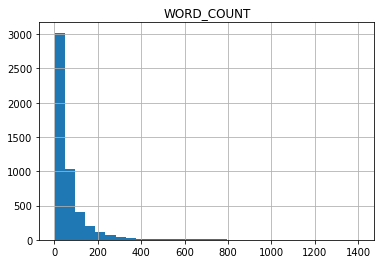

In [35]:
df_raw.hist('WORD_COUNT', bins=30)

In [36]:
df2 = df_raw[['comment_text', 'target_list']].copy()
df2.head()

,comment_text,target_list
0,Explanation\nWhy the edits made under my usern...,"[0, 0, 0, 0, 0, 0]"
1,D'aww! He matches this background colour I'm s...,"[0, 0, 0, 0, 0, 0]"
2,"Hey man, I'm really not trying to edit war. It...","[0, 0, 0, 0, 0, 0]"
3,"""\nMore\nI can't make any real suggestions on ...","[0, 0, 0, 0, 0, 0]"
4,"You, sir, are my hero. Any chance you remember...","[0, 0, 0, 0, 0, 0]"


In [37]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 16
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 4
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [38]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.title = dataframe['comment_text']
        self.targets = self.data.target_list
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [39]:
train_size = 0.8
train_dataset = df2.sample(frac=train_size,random_state=200)
valid_dataset = df2.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df2.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(valid_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
validation_set = CustomDataset(valid_dataset, tokenizer, MAX_LEN)

FULL Dataset: (5000, 2)
TRAIN Dataset: (4000, 2)
TEST Dataset: (1000, 2)


In [40]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **test_params)

In [41]:
len(training_loader)

125

In [42]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 6)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [43]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [44]:
len(training_loader)

125

In [45]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [46]:
import shutil, sys   
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [47]:
#to use as global variables
val_targets=[]
val_outputs=[] 

In [48]:
def train_model(start_epochs,  n_epochs, valid_loss_min_input, 
                training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
   
  # initialize tracker for minimum validation loss
  valid_loss_min = valid_loss_min_input 
   
 
  for epoch in range(start_epochs, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)
    
    print('############# Epoch {}: Training End     #############'.format(epoch))
    
    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
      
      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
        # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))


  return model

In [51]:
checkpoint_path = '/content/sample_data/current_checkpoint.pt'
best_model = '/content/sample_data/best_model.pt'
trained_model = train_model(1, 4, np.Inf, training_loader, validation_loader, model, 
                      optimizer,checkpoint_path,best_model)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000708 	Average Validation Loss: 0.002840
Validation loss decreased (inf --> 0.002840).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000615 	Average Validation Loss: 0.002681
Validation loss decreased (0.002840 --> 0.002681).  Saving model ...
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epo

In [52]:
val_preds = (np.array(val_outputs) > 0.5).astype(int)
val_preds

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [53]:
accuracy = metrics.accuracy_score(val_targets, val_preds)
f1_score_micro = metrics.f1_score(val_targets, val_preds, average='micro')
f1_score_macro = metrics.f1_score(val_targets, val_preds, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.8873333333333333
F1 Score (Micro) = 0.5592730276745146
F1 Score (Macro) = 0.294838611510233


In [54]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report

In [55]:
cm_labels = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']
    
cm = mcm(val_targets, val_preds)

In [56]:
print(classification_report(val_targets, val_preds))

              precision    recall  f1-score   support

           0       0.68      0.56      0.62       600
           1       0.00      0.00      0.00        54
           2       0.65      0.50      0.57       318
           3       0.00      0.00      0.00        24
           4       0.73      0.49      0.58       366
           5       0.00      0.00      0.00        72

   micro avg       0.69      0.47      0.56      1434
   macro avg       0.34      0.26      0.29      1434
weighted avg       0.62      0.47      0.53      1434
 samples avg       0.05      0.05      0.05      1434



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

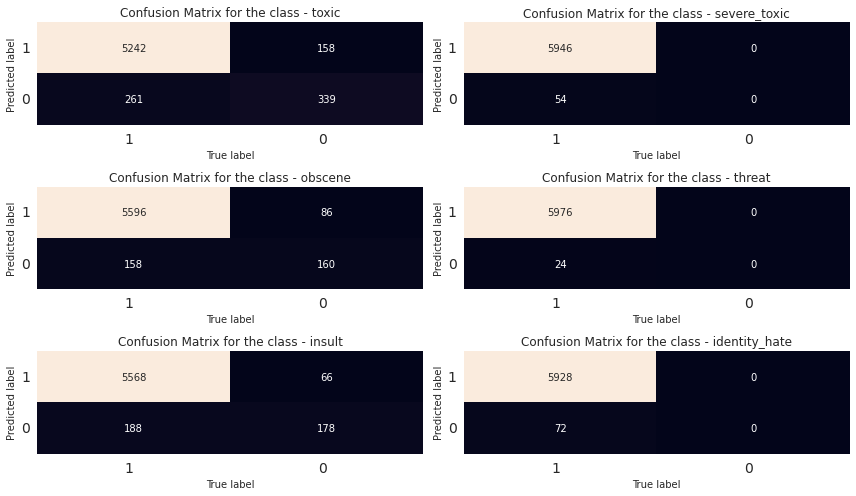

In [58]:
#print_confusion_matrix(mcm(targets, val_preds),class_label=labels, class_names=labels)
sns.set_style("whitegrid")
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, cm_labels):
  print_confusion_matrix(cfs_matrix, axes, label, ["1", "0"])
    
fig.tight_layout()
plt.show()